# Intro
https://link.springer.com/chapter/10.1007/978-981-13-8798-2_12

The dataset referenced in this paper contains 520 observations and 17 attributes that are collected
using direct questionnaires and diagnosis results from the patients in the Sylhet Diabetes Hospital
in Sylhet, Bangladesh. There are 2 demographic features, Age & Gender; the other 15 attributes
are binary features that indicate whether the patient experienced a symptom

By the due date of milestone report on 10/23, we should be able to reproduce the results from the first
paper. For the milestone report, we will each tackle an algorithm and attempt to reproduce the results
from (Islam et al. 2020). With the exception of Decision Tree/Random Forest, this corresponds with
the material taught on the syllabus.

## Explore

In [1]:
# pip install sklearn-pandas

In [2]:
# %pip install --user pandas_profiling

In [3]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

###sklearn
from sklearn import (
    ensemble,
    feature_selection,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    tree,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

# from pandas_profiling import ProfileReport


sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})

In [4]:
sylhet_raw = pd.read_csv("../data/sylhet-dataset.csv")
sylhet_copy = sylhet_raw.copy(deep=True)

In [5]:
sylhet_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [6]:
# profile = ProfileReport(sylhet_copy)

In [7]:
# profile.to_widgets()

In [8]:
col_names = [x.lower().replace(" ", "_") for x in sylhet_copy.columns]

print(col_names)

sylhet_copy.set_axis(col_names, axis=1, inplace=True)

['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class']


In [9]:
y = sylhet_copy["class"].apply(lambda z: 0 if z == "Negative" else 1)
y = y.to_numpy()

In [10]:
sylhet_copy = sylhet_copy.loc[:, :"obesity"]

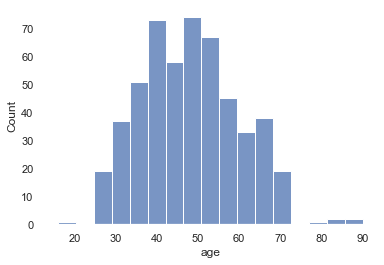

In [11]:
sns.histplot(sylhet_copy, x="age").figure.savefig("age_distribution_histogram.png")

In [12]:
age_binned = pd.qcut(sylhet_copy["age"], q=6)

In [13]:
age_binned

0        (35.0, 42.0]
1        (54.0, 60.0]
2        (35.0, 42.0]
3        (42.0, 47.5]
4        (54.0, 60.0]
            ...      
515      (35.0, 42.0]
516      (47.5, 54.0]
517      (54.0, 60.0]
518    (15.999, 35.0]
519      (35.0, 42.0]
Name: age, Length: 520, dtype: category
Categories (6, interval[float64, right]): [(15.999, 35.0] < (35.0, 42.0] < (42.0, 47.5] < (47.5, 54.0] < (54.0, 60.0] < (60.0, 90.0]]

In [14]:
age_cts = pd.DataFrame(age_binned.value_counts(sort=False, ascending=True))

In [15]:
age_cts.rename(columns={"age": "record_count"})

,record_count
"(15.999, 35.0]",93
"(35.0, 42.0]",88
"(42.0, 47.5]",79
"(47.5, 54.0]",98
"(54.0, 60.0]",82
"(60.0, 90.0]",80


In [16]:
age_cts = age_cts.reset_index()

In [17]:
sylhet_copy["age"] = age_binned

In [18]:
# column_trans = ColumnTransformer(
#     [('age_bins', KBinsDiscretizer(n_bins=6, encode='onehot-dense', strategy='quantile'),['age']),
#       ('one_hot', OneHotEncoder(), list(sylhet_copy.columns[1:-1].values))
#     ],remainder='passthrough'
# )

In [19]:
column_trans = ColumnTransformer(
    [("one_hot", OneHotEncoder(drop="if_binary"), list(sylhet_copy.columns.values))],
    remainder="passthrough",
)

In [20]:
column_trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='if_binary'),
                                 ['age', 'gender', 'polyuria', 'polydipsia',
                                  'sudden_weight_loss', 'weakness',
                                  'polyphagia', 'genital_thrush',
                                  'visual_blurring', 'itching', 'irritability',
                                  'delayed_healing', 'partial_paresis',
                                  'muscle_stiffness', 'alopecia', 'obesity'])])

In [21]:
sylhet_copy.columns

Index(['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss',
       'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
       'itching', 'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity'],
      dtype='object')

In [22]:
sylhet_copy.head(2)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity
0,"(35.0, 42.0]",Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes
1,"(54.0, 60.0]",Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No


In [23]:
column_trans.fit(sylhet_copy)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(drop='if_binary'),
                                 ['age', 'gender', 'polyuria', 'polydipsia',
                                  'sudden_weight_loss', 'weakness',
                                  'polyphagia', 'genital_thrush',
                                  'visual_blurring', 'itching', 'irritability',
                                  'delayed_healing', 'partial_paresis',
                                  'muscle_stiffness', 'alopecia', 'obesity'])])

In [24]:
column_trans.get_feature_names_out()

array(['one_hot__age_(15.999, 35.0]', 'one_hot__age_(35.0, 42.0]',
       'one_hot__age_(42.0, 47.5]', 'one_hot__age_(47.5, 54.0]',
       'one_hot__age_(54.0, 60.0]', 'one_hot__age_(60.0, 90.0]',
       'one_hot__gender_Male', 'one_hot__polyuria_Yes',
       'one_hot__polydipsia_Yes', 'one_hot__sudden_weight_loss_Yes',
       'one_hot__weakness_Yes', 'one_hot__polyphagia_Yes',
       'one_hot__genital_thrush_Yes', 'one_hot__visual_blurring_Yes',
       'one_hot__itching_Yes', 'one_hot__irritability_Yes',
       'one_hot__delayed_healing_Yes', 'one_hot__partial_paresis_Yes',
       'one_hot__muscle_stiffness_Yes', 'one_hot__alopecia_Yes',
       'one_hot__obesity_Yes'], dtype=object)

In [25]:
X = column_trans.transform(sylhet_copy)

In [26]:
X.shape

(520, 21)

In [27]:
MLA = [
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    linear_model.LogisticRegression(),
    tree.DecisionTreeClassifier(),
    ensemble.RandomForestClassifier(),
]

In [28]:
MLA = [
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    linear_model.LogisticRegression(),
    tree.DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=10, max_depth=3),
    ensemble.RandomForestClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=10
    ),
]

In [29]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(
    X, y, random_state=42, train_size=0.8, test_size=0.2
)

In [30]:
print(train1_x.shape, train1_y.shape)
print(test1_x.shape, test1_y.shape)
np.unique(test1_y, return_counts=True)

(416, 21) (416,)
(104, 21) (104,)


(array([0, 1]), array([33, 71]))

In [31]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(
    X, y, random_state=42, train_size=0.8, test_size=0.2, stratify=y
)

In [32]:
print(train1_x.shape, train1_y.shape)
print(test1_x.shape, test1_y.shape)

(416, 21) (416,)
(104, 21) (104,)


In [33]:
np.unique(test1_y, return_counts=True)

(array([0, 1]), array([40, 64]))

In [34]:
score_cols = [
    "Model Name",
    "Precision",
    "Recall",
    "F1",
    "Train Accuracy",
    "Test Accuracy",
]
model_compare = pd.DataFrame(columns=score_cols)

In [35]:
results_conf = pd.DataFrame(
    columns=[
        "true_negative",
        "false_positive",
        "false_negative",
        "true_positive",
        "model",
    ]
)
results = pd.DataFrame(
    index=["negative", "positive", "model"],
    columns=["precision", "recall", "fbeta", "support"],
)
row_index = 0
for alg in MLA:
    print(alg.__class__.__name__)
    MLA_name = alg.__class__.__name__
    model = alg.fit(train1_x, train1_y)
    y_pred = model.predict(test1_x)
    print(sklearn.metrics.confusion_matrix(test1_y, y_pred), "\n")
    flattened = sklearn.metrics.confusion_matrix(test1_y, y_pred).ravel()
    confusion = pd.DataFrame(
        [flattened],
        columns=["true_negative", "false_positive", "false_negative", "true_positive"],
    )
    confusion["model"] = MLA_name
    results_conf = pd.concat([results_conf, confusion])
    prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
        test1_y, y_pred, average="weighted"
    )
    class_stats = sklearn.metrics.precision_recall_fscore_support(
        test1_y, y_pred, labels=[0, 1], pos_label=1
    )
    class_stats = np.array(class_stats).T
    stats = pd.DataFrame(
        class_stats,
        index=["negative", "positive"],
        columns=["precision", "recall", "fbeta", "support"],
    )
    stats["model"] = MLA_name
    results = pd.concat([results, stats], ignore_index=False)
    model_compare.loc[row_index, "Model Name"] = MLA_name
    model_compare.loc[row_index, "Precision"] = prec
    model_compare.loc[row_index, "Recall"] = recall
    model_compare.loc[row_index, "F1"] = f1
    model_compare.loc[row_index, "Train Accuracy"] = model.score(train1_x, train1_y)
    model_compare.loc[row_index, "Test Accuracy"] = model.score(test1_x, test1_y)

    row_index += 1
results = results.dropna()
results_conf = results_conf.dropna()

BernoulliNB
[[39  1]
 [ 8 56]] 

GaussianNB
[[38  2]
 [ 5 59]] 

LogisticRegression
[[39  1]
 [ 4 60]] 

DecisionTreeClassifier
[[37  3]
 [ 3 61]] 

RandomForestClassifier
[[38  2]
 [ 4 60]] 



In [43]:
print('non-stratified target')
model_compare.loc[model_compare['Model Name']=='DecisionTreeClassifier']

non-stratified target


,Model Name,Precision,Recall,F1,Train Accuracy,Test Accuracy
3,DecisionTreeClassifier,0.942308,0.942308,0.942308,0.90625,0.942308


In [37]:
print('stratified target')
model_compare

stratified target


,Model Name,Precision,Recall,F1,Train Accuracy,Test Accuracy
0,BernoulliNB,0.923737,0.913462,0.91444,0.867788,0.913462
1,GaussianNB,0.935101,0.932692,0.933101,0.877404,0.932692
2,LogisticRegression,0.954134,0.951923,0.952215,0.949519,0.951923
3,DecisionTreeClassifier,0.942308,0.942308,0.942308,0.90625,0.942308
4,RandomForestClassifier,0.943519,0.942308,0.942553,0.908654,0.942308


In [38]:
results_conf["Correctly Classified"] = (
    results_conf["true_negative"] + results_conf["true_positive"]
)
results_conf["Incorrectly Classified"] = (
    test1_y.shape[0] - results_conf["Correctly Classified"]
)

cm_data = results_conf[
    ["model", "Correctly Classified", "Incorrectly Classified"]
].melt("model", var_name="cols", value_name="vals")

In [39]:
cm_data

,model,cols,vals
0,BernoulliNB,Correctly Classified,95
1,GaussianNB,Correctly Classified,97
2,LogisticRegression,Correctly Classified,99
3,DecisionTreeClassifier,Correctly Classified,98
4,RandomForestClassifier,Correctly Classified,98
5,BernoulliNB,Incorrectly Classified,9
6,GaussianNB,Incorrectly Classified,7
7,LogisticRegression,Incorrectly Classified,5
8,DecisionTreeClassifier,Incorrectly Classified,6
9,RandomForestClassifier,Incorrectly Classified,6


In [40]:
cm_data["vals"] = cm_data["vals"] / test1_y.shape[0] * 100

cm_data["vals"] = cm_data["vals"].apply(lambda x: round(x, 1))

cm_data

,model,cols,vals
0,BernoulliNB,Correctly Classified,91.3
1,GaussianNB,Correctly Classified,93.3
2,LogisticRegression,Correctly Classified,95.2
3,DecisionTreeClassifier,Correctly Classified,94.2
4,RandomForestClassifier,Correctly Classified,94.2
5,BernoulliNB,Incorrectly Classified,8.7
6,GaussianNB,Incorrectly Classified,6.7
7,LogisticRegression,Incorrectly Classified,4.8
8,DecisionTreeClassifier,Incorrectly Classified,5.8
9,RandomForestClassifier,Incorrectly Classified,5.8


In [41]:
!pwd

/Users/c92680/Documents/GitHub/diabetes-prediction-comparison/notebooks


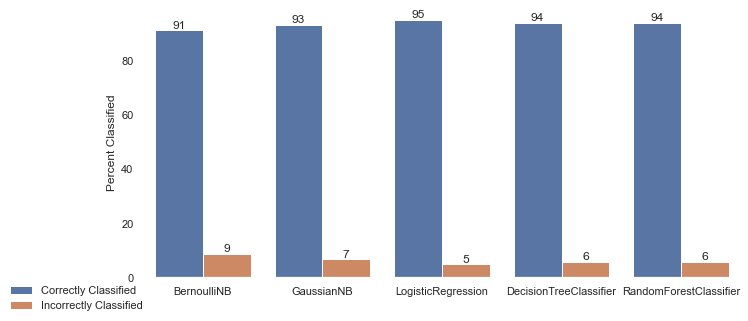

In [42]:
# plt.figure(figsize=(10,5))
g = sns.catplot(data=cm_data, y="vals", x="model", hue="cols", kind="bar")
g.despine(left=True)
g.set_axis_labels("", "Percent Classified")
g.legend.set_title("")
sns.move_legend(g, "lower left")
g.figure.set_size_inches(14.5, 4.5)

# sns.barplot(data=results_conf,y='incorrectly_classified',x='model')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f"{(v.get_height()):.0f}" for v in c]
    ax.bar_label(c, labels=labels, label_type="edge")
# g.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# g.fig.suptitle(
#     "Figure3 - classification with percentage split (80:20) technique and default hyperparameters",
#     horizontalalignment="left",
#     x=0.1,
#     y=1.1,
# )
g.savefig(
    "Figure3 - classification with percentage split technique and default hyperparameters.png"
)

In [ ]:
print("class_stats_percentage_split")
results

In [ ]:
results = results.reset_index()

In [ ]:
results = results.rename(columns={"index": "class"})

In [ ]:
results = results[["class", "precision", "recall", "fbeta", "model"]]

In [ ]:
results = results.rename(
    columns={
        "precision": "Precision",
        "recall": "Recall",
        "fbeta": "F1",
        "model": "Model Name",
    }
)

In [ ]:
print("model_compare")
model_compare["class"] = "weighted"

In [ ]:
model_compare = model_compare[["class", "Precision", "Recall", "F1", "Model Name"]]

In [ ]:
pd.concat([results, model_compare], ignore_index=True, axis=0)

In [ ]:
print(X.shape, y.shape)

In [ ]:
# split dataset in cross-validation with this splitter class:
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
# note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(
    n_splits=10, test_size=0.3, train_size=0.7, random_state=0
)

# create table to compare MLA metrics
MLA_columns = [
    "MLA Name",
    "MLA Parameters",
    "MLA Train Accuracy Mean",
    "MLA Test Accuracy Mean",
    "MLA Test Accuracy 3*STD",
    "MLA Time",
]
MLA_compare = pd.DataFrame(columns=MLA_columns)

# create table to compare MLA predictions
MLA_predict = y

In [ ]:
for train, test in cv_split.split(X, y):
    # print('train -  {}   |   test -  {}'.format(
    #     np.bincount(y[train]), np.bincount(y[test])))
    print('train -  {0}   |   test -  {1}'.format(
        np.round(np.bincount(y[train])/np.bincount(y[train]).sum(),2),
        np.round(np.bincount(y[test])/np.bincount(y[test]).sum(),2)))

In [ ]:
for train, test in skf.split(X, y):
    # print('train -  {}   |   test -  {}'.format(
    #     np.bincount(y[train]), np.bincount(y[test])))
    print('train -  {t1} |   test - {t2} '.format(
        t1=np.round(np.bincount(y[train])/np.bincount(y[train]).sum(),2),
        t2=np.round(np.bincount(y[test])/np.bincount(y[test]).sum(),2)))

In [ ]:
fig, ax = plt.subplots()
cv = KFold(10)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
for train, test in skf.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

In [ ]:
cv_split = model_selection.ShuffleSplit(
    n_splits=10, train_size=0.8, test_size=0.2, random_state=42
)

In [ ]:
cv_split = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [ ]:
cv_split

In [ ]:


results_conf = pd.DataFrame(
    columns=[
        "true_negative",
        "false_positive",
        "false_negative",
        "true_positive",
        "model",
    ]
)
results_conf2 = pd.DataFrame(
    index=["negative", "positive", "model"],
    columns=["precision", "recall", "fbeta", "support"],
)
# index through MLA and save performance to table
row_index = 0
for alg in MLA:

    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, "MLA Name"] = MLA_name
    MLA_compare.loc[row_index, "MLA Parameters"] = str(alg.get_params())

    # score model with cross validation:
    # http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(
        alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
    )

    MLA_compare.loc[row_index, "MLA Time"] = cv_results["fit_time"].mean()
    MLA_compare.loc[row_index, "MLA Train Accuracy Mean"] = cv_results[
        "train_score"
    ].mean()
    MLA_compare.loc[row_index, "MLA Test Accuracy Mean"] = cv_results[
        "test_score"
    ].mean()
    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, "MLA Test Accuracy 3*STD"] = (
        cv_results["test_score"].std() * 3
    )  # let's know the worst that can happen!

    # save MLA predictions - see section 6 for usage
    model = alg.fit(X, y)
    y_pred = alg.predict(X)

    print(
        sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary"),
        "\n",
    )
    prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
        y, y_pred, average="binary"
    )

    flattened = sklearn.metrics.confusion_matrix(y, y_pred).ravel()

    confusion = pd.DataFrame(
        [flattened],
        columns=["true_negative", "false_positive", "false_negative", "true_positive"],
    )
    confusion["model"] = MLA_name
    results_conf = pd.concat([results_conf, confusion])

    #
    weighted_stats = sklearn.metrics.precision_recall_fscore_support(
        y, y_pred, average="binary"
    )
    weighted_stats = np.array(weighted_stats).T
    weighted_stats = weighted_stats.reshape(1, -1)
    class_stats = sklearn.metrics.precision_recall_fscore_support(
        y, y_pred, labels=[0, 1], pos_label=1
    )
    class_stats = np.array(class_stats).T
    weighted = pd.DataFrame(
        weighted_stats,
        index=["weighted"],
        columns=["precision", "recall", "fbeta", "support"],
    )
    weighted["model"] = MLA_name
    weighted["support"] = 520

    stats = pd.DataFrame(
        class_stats,
        index=["negative", "positive"],
        columns=["precision", "recall", "fbeta", "support"],
    )
    stats["model"] = MLA_name

    results_conf2 = pd.concat([results_conf2, weighted, stats], ignore_index=False)

    model_compare.loc[row_index, "Model Name"] = MLA_name
    model_compare.loc[row_index, "Precision"] = prec
    model_compare.loc[row_index, "Recall"] = recall
    model_compare.loc[row_index, "F1"] = f1
    model_compare.loc[row_index, "Train Accuracy"] = cv_results["train_score"].mean()
    model_compare.loc[row_index, "Test Accuracy"] = cv_results["test_score"].mean()

    row_index += 1


results_conf = results_conf.dropna()
results_conf2 = results_conf2.dropna()
# print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by=["MLA Test Accuracy Mean"], ascending=False, inplace=True)
MLA_compare
# MLA_predict

In [ ]:
results_conf2

In [ ]:
for train, test in cv_split.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

In [ ]:
model_compare #(STRATIFIED)

In [ ]:
for train, test in cv_split.split(X, y):
    print('train -  {}   |   test -  {}'.format(
        np.bincount(y[train]), np.bincount(y[test])))

In [ ]:
180+288

In [ ]:
468/520

In [ ]:
468+52

In [ ]:
print("10fold class stats")
results_conf2

In [ ]:
results_conf2.dropna()

In [ ]:
weighted_stats

In [ ]:
results_conf

In [ ]:
stats

In [ ]:
# class_stats = sklearn.metrics.precision_recall_fscore_support(
#     test1_y, y_pred, labels=[0, 1], pos_label=1
# )
# class_stats = np.array(class_stats).T
# stats = pd.DataFrame(
#     class_stats,
#     index=["negative", "positive"],
#     columns=["precision", "recall", "fbeta", "support"],
# )

In [ ]:
results_conf["Correctly Classified"] = (
    results_conf["true_negative"] + results_conf["true_positive"]
)
results_conf["Incorrectly Classified"] = (
    y.shape[0] - results_conf["Correctly Classified"]
)

cm_data = results_conf[
    ["model", "Correctly Classified", "Incorrectly Classified"]
].melt("model", var_name="cols", value_name="vals")

In [ ]:
results_conf

In [ ]:
cm_data

In [ ]:
cm_data["vals"] = cm_data["vals"] / y.shape[0] * 100

cm_data["vals"] = cm_data["vals"].apply(lambda x: round(x, 1))

cm_data

In [ ]:
# plt.figure(figsize=(10,5))
g = sns.catplot(data=cm_data, y="vals", x="model", hue="cols", kind="bar")
g.despine(left=True)
g.set_axis_labels("", "Percent Classified")
g.legend.set_title("")
sns.move_legend(g, "lower left")
g.figure.set_size_inches(14.5, 4.5)

# sns.barplot(data=results_conf,y='incorrectly_classified',x='model')
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)

# iterate through the axes containers
for c in ax.containers:
    labels = [f"{(v.get_height()):.0f}" for v in c]
    ax.bar_label(c, labels=labels, label_type="edge")
# g.fig.suptitle(
#     "Figure2 - Classification with 10-fold cross validation technique and default hyperparameter",
#     horizontalalignment="left",
#     x=0.1,
#     y=1.1,
# )
g.savefig(
    "figure2 - classification with cross validation technique and default hyperparameter.png"
)

In [ ]:
print("10-Fold CV Results")
model_compare

## Variable Importance stuff

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
sylhet_raw = pd.read_csv("../data/sylhet-dataset.csv")
sylhet_copy = sylhet_raw.copy(deep=True)
col_names = [x.lower().replace(" ", "_") for x in sylhet_copy.columns]
sylhet_copy.set_axis(col_names, axis=1, inplace=True)
age_binned = pd.qcut(sylhet_copy["age"], q=6)
sylhet_copy["age"] = age_binned
# sylhet_copy['age'] = sylhet_copy['age'].astype('float')
y = sylhet_copy["class"].apply(lambda z: 0 if z == "Negative" else 1)

In [22]:
dt = tree.DecisionTreeClassifier(random_state=42)

In [23]:
np.linspace(0,1.0,num=11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [24]:
param_grid = {
    "dt__max_depth": [1,3,5],
    "dt__min_samples_leaf" :[5,10,20,30],
    "dt__min_samples_split" :[5,10,20,30]
}

In [25]:
tree.DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [26]:
column_trans = ColumnTransformer(
    [("one_hot", OneHotEncoder(drop="if_binary"), list(sylhet_copy.columns.values),)],
    remainder="drop",
)

In [27]:
dt = Pipeline(
    [
        ("column_trans", column_trans),
        ("dt",tree.DecisionTreeClassifier(random_state=42)),
    ]
)

# dt.fit(X_train, y_train)

In [28]:
clf = GridSearchCV(dt, param_grid,return_train_score=True)

In [29]:
sylhet_copy.shape

(520, 17)

In [30]:
clf.fit(sylhet_copy, y)

GridSearchCV(estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['age',
                                                                          'gender',
                                                                          'polyuria',
                                                                          'polydipsia',
                                                                          'sudden_weight_loss',
                                                                          'weakness',
                                                                          'polyphagia',
                                                                          'genital_thrush',
                                                     

In [31]:
clf.best_score_
clf.best_params_

{'dt__max_depth': 1, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 5}

In [32]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_dt__max_depth', 'param_dt__min_samples_leaf', 'param_dt__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [33]:
clf.cv_results_

{'mean_fit_time': array([0.01114335, 0.00840988, 0.00843978, 0.01027803, 0.00961661,
        0.00727658, 0.00728464, 0.00867805, 0.00737729, 0.00831718,
        0.00857878, 0.00924602, 0.0073761 , 0.00834045, 0.0080205 ,
        0.00708451, 0.00714688, 0.00883441, 0.00730844, 0.00740824,
        0.00801735, 0.00734911, 0.00717545, 0.00723529, 0.00706897,
        0.00725946, 0.0070343 , 0.00747266, 0.00725088, 0.00718198,
        0.00750828, 0.00758405, 0.0073791 , 0.00732121, 0.00754161,
        0.0078805 , 0.01026821, 0.00829992, 0.00724359, 0.00694594,
        0.00720401, 0.00759225, 0.00784402, 0.00820222, 0.00942235,
        0.00744338, 0.00716257, 0.00732374]),
 'std_fit_time': array([7.74597426e-04, 1.02114931e-03, 1.06472495e-03, 3.85081756e-04,
        1.04506756e-03, 1.84202657e-04, 7.95292336e-05, 1.27686365e-03,
        5.07886879e-04, 1.13490149e-03, 9.52283740e-04, 1.22426911e-03,
        1.21006822e-04, 1.44917590e-03, 1.26375529e-03, 1.58526132e-04,
        1.96254751e-0

In [ ]:
X_train.columns.values

In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    sylhet_copy.iloc[:, :-1],
    y,
    stratify=y,
    random_state=42,
    train_size=0.8,
    test_size=0.2,
)

In [36]:
column_trans = ColumnTransformer(
    [("one_hot", OneHotEncoder(drop="if_binary"), list(X_train.columns.values),)],
    remainder="drop",
)

In [37]:
dt = Pipeline(
    [
        ("column_trans", column_trans),
        ("classifier",tree.DecisionTreeClassifier(random_state=42)),
    ]
)

dt.fit(X_train, y_train)

feature_names = dt[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    dt[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

In [38]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "classifier__max_depth": [1, 3, 5],
    "classifier__min_samples_leaf": [5,10,15,20],
    "classifier__min_samples_split": [5,10,15,20]
}
search = GridSearchCV(dt, param_grid, n_jobs=2)
search.fit(sylhet_copy, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.925):
{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 5}


In [46]:
dt2 = Pipeline(
    [
        ("column_trans", column_trans),
        ("classifier", tree.DecisionTreeClassifier(random_state=42,max_depth=3, min_samples_leaf=10, min_samples_split=5)),
    ]
)

dt2.fit(X_train, y_train)

feature_names = dt2[:-1].get_feature_names_out()
mdi_importances2 = pd.Series(
    dt2[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

In [47]:
dt2[-1].feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16289508, 0.58283066, 0.14471094, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04359373,
       0.        , 0.        , 0.        , 0.        , 0.0659696 ,
       0.        ])

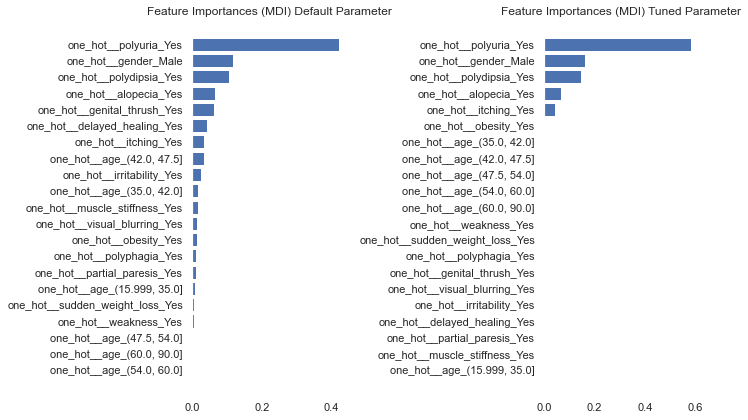

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
ax1.barh(y=mdi_importances.index, width=mdi_importances)
ax1.set_title("Feature Importances (MDI) Default Parameter")
ax1.figure.tight_layout()

ax2.barh(y=mdi_importances2.index, width=mdi_importances2)
ax2.set_title("Feature Importances (MDI) Tuned Parameter")
ax2.figure.tight_layout()
fig.savefig('compare-trees.png')

In [ ]:
dot_data = tree.export_graphviz(
    dt2[-1],
    filled=True,
    rounded=True,
    special_characters=True,
    out_file="bigtree.dot",
    feature_names=column_trans.get_feature_names_out(),
    class_names=["No Diabetes", "Diabetes"],
)

In [ ]:
graph = graphviz.render(
    "dot", filepath="bigtree.dot", outfile="final_tree.png"
).replace("\\", "/")
graph

In [ ]:
rf = Pipeline(
    [
        ("column_trans", column_trans),
        ("classifier", ensemble.RandomForestClassifier(random_state=42)),
    ]
)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
print(f"{rf.score(X_train, y_train):.3f}")
print(f"{rf.score(X_test, y_test):.3f}")

In [ ]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

In [ ]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [ ]:
cv_results = model_selection.cross_validate(
    alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
)

# rf_model = rf.fit(train1_x, train1_y)
# rf_pred = rf.predict(X)
# save MLA predictions - see section 6 for usage
model = alg.fit(X, y)
y_pred = alg.predict(X)

In [ ]:
feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

In [ ]:
sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary")

In [ ]:
prec, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(
    y, y_pred, average="binary"
)

In [ ]:
variable_importance = pd.DataFrame(
    model.feature_importances_,
    index=column_trans.get_feature_names_out().tolist(),
    columns=["importance"],
)

In [ ]:
variable_importance.sort_values("importance", ascending=False)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
r = permutation_importance(alg, X, y, n_repeats=10, random_state=0)

In [ ]:
r

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(i, f"{r.importances_mean[i]:.3f}", f" +/- {r.importances_std[i]:.3f}")

In [ ]:
import graphviz

In [ ]:
dot_data = tree.export_graphviz(
    model,
    filled=True,
    rounded=True,
    special_characters=True,
    out_file="bigtree.dot",
    feature_names=column_trans.get_feature_names_out(),
    class_names=["No Diabetes", "Diabetes"],
)

In [ ]:
graph = graphviz.render(
    "dot", filepath="bigtree.dot", outfile="final_tree.png"
).replace("\\", "/")
graph

In [ ]:
graphviz.Source(dot_data)

In [ ]:
graph

In [ ]:
dot_data = sklearn.tree.export_graphviz(
    model,
    out_file="tree.dot",
    filled=True,
    rounded=True,
    special_characters=True
    # feature_names=column_trans.get_feature_names_out(),
    # class_names=["No Diabetes", "Diabetes"],
)

In [ ]:
graph = graphviz.Source(dot_data)

In [ ]:
graph

In [ ]:
model.estimators_[0]

In [ ]:
dot_data = export_graphviz(
    model.estimators_[0],
    out_file="tree.dot",
    feature_names=column_trans.get_feature_names_out(),
    class_names=["Diabetes", "No Diabetes"],
    rounded=True,
    proportion=False,
    precision=2,
    filled=True,
)

In [ ]:
!dot -V

In [ ]:
from subprocess import call

call(["dot", "-Tpng", "tree.dot", "-o", "tree.png", "-Gdpi=600"])

In [ ]:
import graphviz

In [ ]:
graph = graphviz.Source(dot_data)

In [ ]:
graph

In [ ]:
import shap

In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
len(shap_values)

In [ ]:
sylhet_copy.columns

In [ ]:
my_fig = shap.summary_plot(
    shap_values, features=X, feature_names=column_trans.get_feature_names_out(),
)

In [ ]:
alg = linear_model.LogisticRegression(penalty="l1", solver="liblinear")

In [ ]:
cv_results = model_selection.cross_validate(
    alg, X, y, cv=cv_split, return_train_score=True, scoring="f1_macro",
)

# save MLA predictions - see section 6 for usage
model = alg.fit(X, y)
y_pred = alg.predict(X)

In [ ]:
sklearn.metrics.precision_recall_fscore_support(y, y_pred, average="binary")

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [ ]:
model.coef_

In [ ]:
np.exp(model.coef_)

In [ ]:
var_coef = pd.DataFrame(
    np.exp(model.coef_)[0],
    index=column_trans.get_feature_names_out().tolist(),
    columns=["lr_coefficient"],
)

In [ ]:
var_coef.sort_values("lr_coefficient", ascending=False)

In [ ]:
explainer = shap.LinearExplainer(model, X)
shap_values = explainer.shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X, feature_names=column_trans.get_feature_names_out())

In [ ]:
# barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x="MLA Test Accuracy Mean", y="MLA Name", data=MLA_compare, color="m")

# prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title("Machine Learning Algorithm Accuracy Score \n")
plt.xlabel("Accuracy Score (%)")
plt.ylabel("Algorithm")

In [ ]:
MLA_compare